<a href="https://colab.research.google.com/github/cp-sadag/public-datasets/blob/main/Team_1_Capstone_Project_FTIR_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Capstone Poject - Team 1: Identifying Functional Groups from FTIR Data

## Objectives & Problem Statement

**Fourier Transform Infrared Spectroscopy (FTIR)** is a ubiquitous spectroscopic technique. Spectral interpretation is a time-consuming process, but it yields important information about functional groups present in compounds and in complex substances. 
*   We will develop a generalizable model via a machine learning (ML) algorithm to identify the presence of functional groups in FTIR spectra. 
*   The ML models will reduce the amount of time required to analyze functional groups and facilitate interpretation of FTIR spectra. 
Through web scraping, we acquire intensity-frequency data from organic molecules. 
*   We successfully train models for 7 of the most common organic functional groups, which we then determine via identification from previously untrained spectra. 
*   These models serve to expand the application of FTIR measurements for facile analysis of organic samples. 

Our approach was done such that we have broad functional group models that inference in tandem to provide full interpretation of a spectrum. We will present the implementation of ML for predicting functional groups from a spectroscopic method.

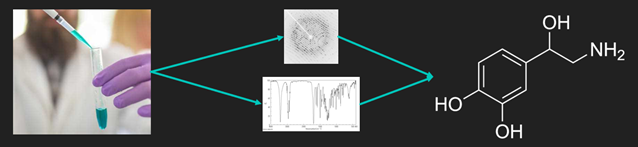



### Import required packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import random
from bs4 import BeautifulSoup
from IPython.display import SVG

import warnings
warnings.filterwarnings("ignore")

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import ClassifierChain

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

#CNN
import tensorflow as tf 
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential,load_model,Model
from keras.layers import Input,Activation,Dense,LSTM
from keras.layers import Flatten,Dropout,BatchNormalization
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D
from keras.layers import Conv2D,MaxPooling2D,GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D

### Dataset

Description<br>
A collection of files in SVG format containing FTIR Spectroscopy data i.e. Wave Number vs Transmittance graphs for various organic compounds. A corresponding set of CAS IDs (unique identifier for compounds) and SMILES (a codified representation of molecular formula)

*  CAS: Chemical Abstracts Service: Registry Number is a unique identifier for chemical compound.
*  SMILES: The simplified molecular-input line-entry system is a specification in the form of a line notation for describing the structure of chemical species using short ASCII strings. 

Data Sources
*  PubChem (https://pubchem.ncbi.nlm.nih.gov/)
*  NIST Chemistry Webbook (https://webbook.nist.gov/)
*  Github dataset (https://github.com/cp-sadag/public-datasets/blob/main/iridescent/)

Crawling Process
1.	Download list of CAS IDs and SMILES from the PubChem website
2.	Using CAS ID download SVGs from the NIST Chemistry Webbook website.
3.  Store the SVGs and labels in a public folder in Github

Crawling Tools
*  Beautiful soup: It is a Python library that is used for web scraping purposes to pull the data out of HTML and XML files, used to parse the data from the website
*  Urllib: For converting the compound name and CAS ID into relevant URL.
*  Request: Requests will allow you to send HTTP/1.1 requests using Python. With it, you can add content like headers, form data, multipart files, and parameters via simple Python libraries used to download the SVG files from the website
*  Selenium Web Driver: It is a collection of open-source APIs which are used to automate the testing of a web application, we used to crawl through dynamic pages used on the website.
*  RDKit: It is a collection of cheminformatics and machine-learning software written in C++ and Python (BSD license). RdKit library is used to label the smiles for their respective functional group. Please see [RDKit Fragments](http://rdkit.org/docs/source/rdkit.Chem.Fragments.html) module to identify 85 functional groups in a molecule using SMILES code.

Summary of the data collected by crawling:<br>
<Table align=left>
<tr><td rowspan=2><b>Website</td><td colspan=3><b>PubChem</td><td colspan=2><b>NIST</td><td rowspan=2><b>Total</td></tr>
<tr><td><b>Crawled</td><td><b>SMILES</td><td><b>w/o SMILES</td><td><b>SVG</td><td><b>w/o SVG</td></tr>
<tr align=right><td><b>Manual</td><td>0</td><td>981</td><td>52</td><td>1,033</td><td>0</td><td>981</td></tr>
<tr align=right><td><b>Crawler Phase 1</td><td>32,000</td><td>22,000</td><td>0</td><td>3,923</td><td>18,077</td><td>3,923</td></tr>
<tr align=right><td><b>Crawler Phase 2</td><td>28,000</td><td>33,000</td><td>0</td><td>3,467</td><td>29,533</td><td>3,467</td></tr>
<tr align=right><td><b>Crawler Phase 3</td><td>40,000</td><td>40,000</td><td>0</td><td>-</td><td>-</td><td>0</td></tr>
<tr align=right><td><b>Total</td><td><b>1,00,000</td><td><b>95,981</td><td><b>52</td><td><b>8,423</td><td><b>47,610</td><td><b>8,371</td></tr>
</Table>

SVG Files

In [ ]:
%%capture
!wget "https://github.com/cp-sadag/public-datasets/blob/main/iridescent/allsvgs.zip?raw=true" -O InputData.zip
!unzip "InputData.zip"

In [ ]:
pathlist = Path(os.getcwd()).glob('**/allsvgs/*.svg')
print('Total SVGs extracted:',len(list(pathlist)))

Total SVGs extracted: 7379


Labels Data<br>
This has been prepared by compiling the SMILES code for all the CASIDs in the data, and fetching the functional groups based on the SMILES code using the Fragments module in the RDKit library

In [ ]:
url="https://github.com/cp-sadag/public-datasets/blob/main/iridescent/Crawl_Rdkit_all.csv?raw=true"
df_labels=pd.read_csv(url)

In [ ]:
df_labels.head(5)

,Compound_name,smiles,Molecular_Formula,CAS,InChI_Key,InChI,PubChemID,ID,aliphatic_carboxylic_acids,aliphatic_hydroxyl_groups,aliphatic_hydroxyl_groups_excluding_tert-OH,N_functional_groups_attached_to_aromatics,Aromatic_carboxylic_acide,aromatic_nitrogens,aromatic_amines,aromatic_hydroxyl_groups,carboxylic_acids,carbonyl_O,"carbonyl_O,_excluding_COOH",thiocarbonyl,C(OH)CCN-Ctert-alkyl_or_C(OH)CCNcyclic,Imines,Tertiary_amines,Secondary_amines,Primary_amines,hydroxylamine_groups,XCCNR_groups,"tert-alicyclic_amines_(no_heteroatoms,_not_quinine-like_bridged_N)",H-pyrrole_nitrogens,thiol_groups,aldehydes,alkyl_carbamates_(subject_to_hydrolysis),alkyl_halides,allylic_oxidation_sites_excluding_steroid_dienone,amides,amidine_groups,anilines,aryl_methyl_sites_for_hydroxylation,azide_groups,azo_groups,...,hydrazine_groups,hydrazone_groups,imidazole_rings,imide_groups,isocyanates,isothiocyanates,ketones,"ketones_excluding_diaryl,_a,b-unsat._dienones,_heteroatom_on_Calpha",beta_lactams,cyclic_esters_(lactones),methoxy_groups_-OCH3,morpholine_rings,nitriles,nitro_groups,nitro_benzene_ring_substituents,non-ortho_nitro_benzene_ring_substituents,"nitroso_groups,_excluding_NO2",oxazole_rings,oxime_groups,para-hydroxylation_sites,phenols,phenolic_OH_excluding_ortho_intramolecular_Hbond_substituents,phosphoric_acid_groups,phosphoric_ester_groups,piperdine_rings,piperzine_rings,primary_amides,primary_sulfonamides,pyridine_rings,quarternary_nitrogens,thioether,sulfonamides,sulfone_groups,terminal_acetylenes,tetrazole_rings,thiazole_rings,thiocyanates,thiophene_rings,unbranched_alkanes_of_at_least_4_members_(excludes_halogenated_alkanes),urea_groups
0,"Silane, butylchlorodimethyl-",CCCC[Si](C)(C)Cl,C6H15ClSi,C1000506,MXOSTENCGSDMRE-UHFFFAOYSA-N,"InChI=1S/C6H15ClSi/c1-4-5-6-8(2,3)7/h4-6H2,1-3H3",66079,46716,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"2,4-Dimethyl-1,3-pentadiene",CC(=CC(=C)C)C,C7H12,C1000868,CMSUNVGIWAFNBG-UHFFFAOYSA-N,"InChI=1S/C7H12/c1-6(2)5-7(3)4/h5H,1H2,2-4H3",66080,46717,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Tetramethylallene,CC(=C=C(C)C)C,C7H12,C1000879,DZSNJASVIURWOG-UHFFFAOYSA-N,InChI=1S/C7H12/c1-6(2)5-7(3)4/h1-4H3,66081,46718,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4-Nitrobenzyl bromide,C1=CC(=CC=C1CBr)[N+](=O)[O-],C7H6BrNO2,C100118,VOLRSQPSJGXRNJ-UHFFFAOYSA-N,InChI=1S/C7H6BrNO2/c8-5-6-1-3-7(4-2-6)9(10)11/...,66011,46649,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6-Pentadecanone,CCCCCCCCCC(=O)CCCCC,C15H30O,C1001452,YSHXMTRDMDYAEC-UHFFFAOYSA-N,InChI=1S/C15H30O/c1-3-5-7-8-9-10-12-14-15(16)1...,70476,50783,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
#Keep only CASID column and the function group columns
df_labels.drop(columns=['Compound_name','smiles','Molecular_Formula','InChI_Key','InChI','PubChemID','ID'],axis=1,inplace=True)

**SVG Parser**:<bR>
Function to parse the SVG files using Beautiful Soup. The library helps identify different meta tags in the SVG file based on which, the Wave numbers and transmittance percenatage for every datapoint on the line chart.<br>
More importantly, each SVG file has **different scales** for X & Y axis, and some of them are in micrometers instead of Wave number. The parser is able to standardize the units of measurement and also scale the data to the absolute value of wavenumber and transmission, thereby **standardizing** the entire dataset. 


In [ ]:
def parse_svg (filename):
    
    #Get CAS ID from the filename (naming convention for SVGs is <CASID>.SVG)
    CASID = str(filename).split('\\')[-1].split('/')[-1].split('.')[0]
    
    with open(filename,'r') as html_file:
        content=html_file.read()
        soup=BeautifulSoup(content,'lxml')
        
        #get all text tags.
        tags=soup.find_all('text')
        xaxis=[]
        yaxis=[]
        yunits =0
        data=[]
        for text in tags:
            
            #Look for numeric values to identify x-axis scale and y-axis scale
            if text.text.strip().replace('.', '', 1).isdigit():
                #Less than 1 implies y-axis, i.e. transmittance lies between 0 & 1
                if float(text.text.strip())<=1:
                    yaxis.append([float(text.text.strip()), float(text['x']),float(text['y'])])
                else:
                    xaxis.append([float(text.text.strip()), float(text['x']),float(text['y'])])
            
            #Check the x-axis label units (for wavenumber vs micrometer) to handle conversion
            if text.text.strip().lower().find('wave')>-1:
                xunits=text.text.strip().lower()
                xunits_flag=0
            if text.text.strip().lower().find('micro')>-1:
                xunits=text.text.strip().lower()
                xunits_flag=1
            #Look for y-axis label that is based on transmittance. 
            if text.text.strip().lower().find('trans')>-1:
                yunits=text.text.strip().lower()

        #If y-axis label is not transmittance, reject the sample
        if yunits!=0:
          #calculate the scaling factor for wave number
          wave_factor=0.0
          for i in range(len(xaxis)-1):
              wave_factor += abs(xaxis[i+1][0]-xaxis[i][0])/abs(xaxis[i+1][1]-xaxis[i][1])
          wave_factor =wave_factor/(len(xaxis)-1)

          #Identify the zero position on x-axis to get the distance of each data point (wavenumber) on the graph.
          wave_interval = xaxis[1][0]-xaxis[0][0]
          svg_interval =  xaxis[1][1]-xaxis[0][1]
          xzero= xaxis[0][1] - (xaxis[0][0]/wave_interval)*svg_interval

          #calculate the scaling factor for transmittance
          t_factor=0.0
          for i in range(len(yaxis)-1):
              t_factor += abs(yaxis[i+1][0]-yaxis[i][0])/abs(yaxis[i+1][2]-yaxis[i][2])
          t_factor =t_factor/(len(yaxis)-1)

          #Identify the zero position on y-axis to get the distance of each data point (transmittance) on the graph.
          trans_interval = yaxis[1][0]-yaxis[0][0]
          svg_t_interval =  yaxis[1][2]-yaxis[0][2]
          yzero= yaxis[0][2] - (yaxis[0][0]/trans_interval)*svg_t_interval


          #get all the points in the line (co-ordinates of the data in SVG)
          lst = soup.find_all('polyline')[-1]['points'].split ("\n")
          
          for item in lst:
              wave,trans = item.split(",")
              wave=(xzero-float(wave)) * wave_factor
              if xunits_flag == 1:
                  wave =10000/wave
              trans = (yzero-float(trans)) * t_factor
              data.append ([CASID, wave,trans,xunits,yunits])
          
        else:
          data.append([CASID, 0,0,'x','y'])
        
        cols = ['CASID', 'wave_no', 'trans', 'xunits','yunits']
        try:
          df = pd.DataFrame(data=data,columns=cols)
        except:
          df = pd.DataFrame(data=[CASID, 0,0,'x','y'],columns=cols)
        return df 

**Multiprocessing to read ~7K SVGs**<br>
Sequential reading of the SVG files through the parser takes about 2 hours to process 7379 images. In order to optimize this process we have implemented multiprocessing that creates several parallel threads and executes the entire batch of 7379 SVG files in less than 2 minutes! It is 60x faster!!! 
<br>
~***14 Millions*** rows are generated in all from the SVG files as shown below:

In [ ]:
import multiprocessing as mp
df = pd.DataFrame()
pathlist = list(Path(os.getcwd()).glob('**/allsvgs/*.svg'))
with mp.Pool(4) as pool:
    result = pool.imap(parse_svg, pathlist, chunksize=50)
    df=pd.concat([r for r in result], ignore_index=True)

df

,CASID,wave_no,trans,xunits,yunits
0,C6137037,549.998473,0.999572,wavenumber (cm-1),relative transmittance
1,C6137037,553.998758,0.999745,wavenumber (cm-1),relative transmittance
2,C6137037,557.999043,0.999889,wavenumber (cm-1),relative transmittance
3,C6137037,561.999328,0.999795,wavenumber (cm-1),relative transmittance
4,C6137037,565.999613,0.999678,wavenumber (cm-1),relative transmittance
...,...,...,...,...,...
13896559,C7730203,467.994468,0.624091,wavenumber (cm-1),transmitance
13896560,C7730203,466.995140,0.626192,wavenumber (cm-1),transmitance
13896561,C7730203,465.995812,0.625392,wavenumber (cm-1),transmitance
13896562,C7730203,464.996484,0.625692,wavenumber (cm-1),transmitance


Render the parsed data as a chart to validate it against the SVG file.

In [ ]:
def plot_FTIR(compound):
  fig, plot = plt.subplots(1,1,figsize=(20,6))
  wave_no = df[df['CASID'] == compound]['wave_no']
  trans_rate = df[df['CASID'] == compound]['trans']    
  plot.plot(wave_no, trans_rate)
  plot.title.set_text(compound)
    
  plot.set_xlabel('Wave Number (cm-1)')
  plot.set_ylabel('Transmittance')
  plot.invert_xaxis()
  plot.axhline(y=0, color='k')
  plot.grid(True, which='both')
  plt.show()
  


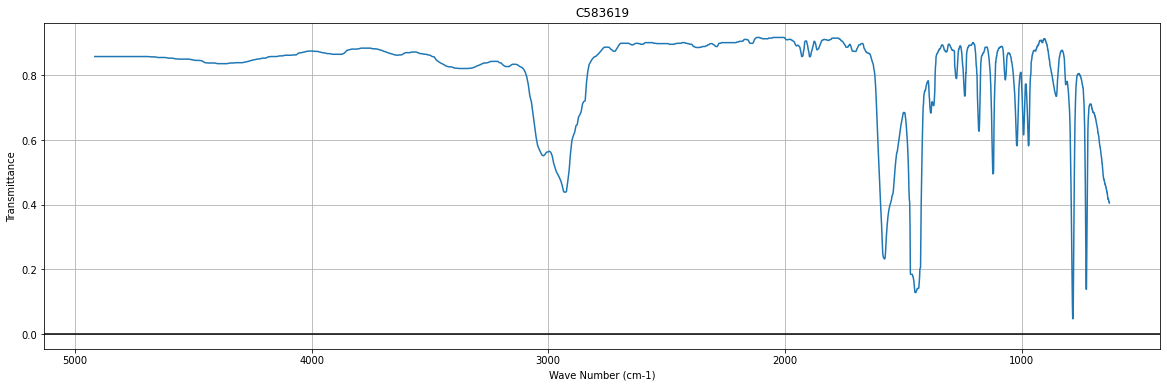

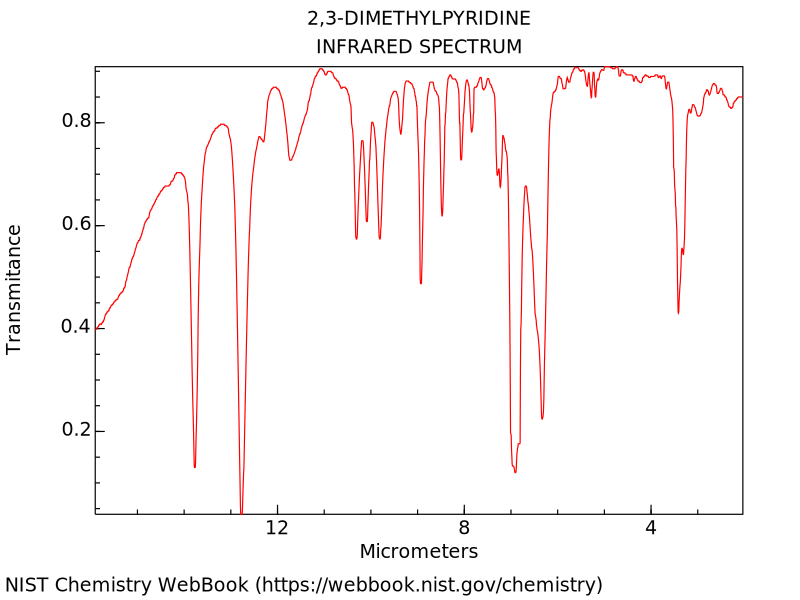

In [ ]:
#Plot the parsed data for a randomly sampled compound and validate it against the SVG file
compound= random.choices(df.CASID.unique())[0]

plot_FTIR(compound)
SVG(filename='allsvgs/'+compound+'.svg')

## Data Preprocessing

In [ ]:
#All the exceptions in the SVG Parser would have been added as rows with 0 wavenumber
df[(df['wave_no']==0)].nunique()

CASID      46
wave_no     1
trans       1
xunits      1
yunits      1
dtype: int64

In [ ]:
#Remove exceptions
df=df[(df['wave_no']>0)]

<u>Scatter plot of Wavenumber vs Transmittance for all the data</u><br>
The commonly used region for infrared spectroscopy is 4000 ~ 400 cm-1 because the absorption radiation of most organic compounds and inorganic ions is within this region. The region between 400 cm-1 and 1500 cm-1 is known as the **fingerprint region**, so called because it’s difficult to assign all the absorption bands, and because of the unique patterns found there. Absorption bands in the 4000 to 1450 cm-1 region are usually due to stretching vibrations of diatomic units, and this is sometimes called the **group frequency region / diagnostic region**. [ Source](https://www.thermofisher.com/blog/materials/all-about-infrared-radiation-and-spectroscopy/)<br>
Please note: Transmittance upto 2 is a valid result.

[Text(0, 0.5, 'Transmittance'), Text(0.5, 0, 'Wave Number')]

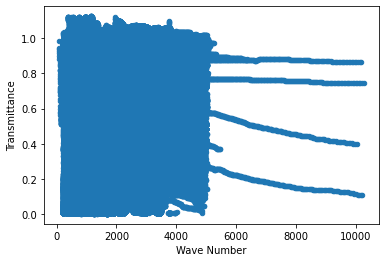

In [ ]:
df.plot.scatter('wave_no','trans').set(xlabel='Wave Number',ylabel='Transmittance')

[Text(0, 0.5, 'Transmittance'), Text(0.5, 0, 'Wave Number')]

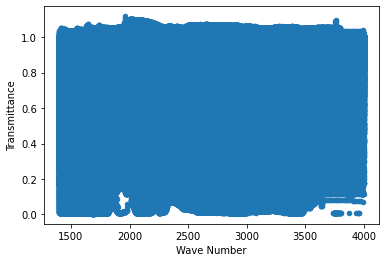

In [ ]:
#remove data < 1400 and > 4000 wavenumber outside of diagnostic region
df=df[(df['wave_no']>=1400) & (df['wave_no']<=4000)]
df.plot.scatter('wave_no','trans').set(xlabel='Wave Number',ylabel='Transmittance')

In [ ]:
#Random sample from the data  
compounds= random.choices(df.CASID.unique(), k=4)
for compound in compounds:
  print(df[df['CASID']==compound].head(5).to_string(index=False),"\n")

   CASID      wave_no     trans             xunits                  yunits
 C592905  1401.998107  0.998471  wavenumber (cm-1)  relative transmittance
 C592905  1405.998392  0.998856  wavenumber (cm-1)  relative transmittance
 C592905  1409.998677  0.998985  wavenumber (cm-1)  relative transmittance
 C592905  1413.998962  0.998801  wavenumber (cm-1)  relative transmittance
 C592905  1417.999247  0.998269  wavenumber (cm-1)  relative transmittance 

    CASID      wave_no     trans             xunits                  yunits
 C6765395  1401.998107  0.999811  wavenumber (cm-1)  relative transmittance
 C6765395  1405.998392  0.999746  wavenumber (cm-1)  relative transmittance
 C6765395  1409.998677  0.999618  wavenumber (cm-1)  relative transmittance
 C6765395  1413.998962  0.999489  wavenumber (cm-1)  relative transmittance
 C6765395  1417.999247  0.999312  wavenumber (cm-1)  relative transmittance 

     CASID      wave_no     trans             xunits        yunits
 C25140867  1400.002095

We observe that while Wave Numbers have data type as float, but it is not conitnuous (1401.xxxx, 1405.xxxx etc), also the interval between two Wave Numbers are not the same for all compounds. Therefore, it would be prudent to <u>round off the Wave Numbers to the nearest integer values</u> and take the minimum Transmittance of the rows having the same Wave Number. 

## Data Engineering

In [ ]:
#Add a new column to bin the Wave Numbers by rounding off to the nearest integer value.
df['bin']=round(df['wave_no'],0).astype(int)

<u>Data Compression</u>
The dataset size ~70M (14 M rows x 5 Columns), We can drop the xunits, yunits, wave_no columns. pivot the table with bin column such that every compound has exactly one row, and transmittance value for each Wave Number from 400 to 4000. This will resize the dataset to 26M (7K compounds x 3600 wave numbers) 

In [ ]:
crosstab = pd.pivot_table(df, values='trans', index=['CASID'],
                    columns=['bin'], aggfunc=np.min)
crosstab

bin,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439,...,3961,3962,3963,3964,3965,3966,3967,3968,3969,3970,3971,3972,3973,3974,3975,3976,3977,3978,3979,3980,3981,3982,3983,3984,3985,3986,3987,3988,3989,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999,4000
CASID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C100005,NaN,0.674516,0.683516,NaN,0.689517,0.695517,0.705516,NaN,0.715516,0.735517,0.747517,NaN,0.761516,0.778518,NaN,0.782517,0.782517,0.780516,NaN,0.763517,0.744517,0.703518,NaN,0.654517,0.549517,0.519518,NaN,0.519518,0.520517,NaN,0.526517,0.556516,0.611517,NaN,0.657517,0.696516,NaN,0.730516,0.758516,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.010517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.010517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.010517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C1000506,NaN,0.547821,0.527723,0.507522,0.487423,0.467223,0.447022,0.438721,0.439223,0.459022,0.441721,0.518822,0.548723,0.578723,0.608621,0.620022,0.630323,0.638621,0.646922,0.656022,0.666521,0.677222,0.688323,0.706623,0.714122,0.721021,0.725522,0.729022,0.729322,0.729222,0.728822,0.727723,0.726222,0.727523,0.713922,0.708421,0.702923,0.687823,0.677322,0.667822,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C100061,NaN,0.900857,0.897857,0.894557,0.890557,0.886457,0.882457,0.878357,0.872157,0.864157,0.856357,0.847956,0.839657,0.831158,0.822057,0.811856,0.779958,0.736357,0.691657,0.669858,0.666057,0.699458,0.723457,0.747558,0.772157,0.796658,0.799458,0.798556,0.795557,0.791657,0.788857,0.788157,0.788457,0.791857,0.798556,0.806357,0.814957,0.821058,0.822858,0.822656,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C1000868,NaN,NaN,0.991717,NaN,NaN,NaN,0.992336,NaN,NaN,NaN,0.992490,NaN,NaN,NaN,0.992232,NaN,NaN,NaN,0.991679,NaN,NaN,NaN,0.990688,NaN,NaN,NaN,0.989468,NaN,NaN,NaN,0.988207,NaN,NaN,NaN,0.986832,NaN,NaN,NaN,0.985367,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C1000879,NaN,NaN,0.998521,NaN,NaN,NaN,0.998410,NaN,NaN,NaN,0.998059,NaN,NaN,NaN,0.997515,NaN,NaN,NaN,0.996785,NaN,NaN,NaN,0.995788,NaN,NaN,NaN,0.994551,NaN,NaN,NaN,0.993172,NaN,NaN,NaN,0.991638,NaN,NaN,NaN,0.990119,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C999644,NaN,NaN,0.995216,NaN,NaN,NaN,0.996212,NaN,NaN,NaN,0.996607,NaN,NaN,NaN,0.996487,NaN,NaN,NaN,0.996006,NaN,NaN,NaN,0.995182,NaN,NaN,NaN,0.993913,NaN,NaN,NaN,0.992115,NaN,NaN,NaN,0.989774,NaN,NaN,NaN,0.987116,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C99978,NaN,NaN,0.937191,NaN,NaN,NaN,0.935001,NaN,NaN,NaN,0.933330,NaN,NaN,NaN,0.930891,NaN,NaN,NaN,0.920695,NaN,NaN,NaN,0.922599,NaN,NaN,NaN,0.917027,NaN,NaN,NaN,0.905113,NaN,NaN,NaN,0.896312,NaN,NaN,NaN,0.869584,NaN,...,NaN,1.006212,NaN,NaN,NaN,1.006212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C999815,0.693353,0.677653,0.661853,0.656253,0.654452,0.652652,0.650752,0.652153,0.657153,0.66225

The crosstab thus created has a lot of blank cells for the following reasons:
1. Not all compounds have data for transmittance from 400 to 4000 wave numbers.
2. Not all compounds have Wave Number interval of 1 or less. For the compounds that have Wave Number interval of 5, the values between 1 to 5 will appear blank.


To mitigate this, we will interpolate the transmittance values both forward and backward linearly to fill all the cells.

In [ ]:
crosstab.interpolate(method ='linear',axis=1, limit_direction ='both',inplace=True)

In [ ]:
#reset the index so that CASID is column in the dataset
crosstab.reset_index()

bin,CASID,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1438,...,3961,3962,3963,3964,3965,3966,3967,3968,3969,3970,3971,3972,3973,3974,3975,3976,3977,3978,3979,3980,3981,3982,3983,3984,3985,3986,3987,3988,3989,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999,4000
0,C100005,0.674516,0.674516,0.683516,0.686517,0.689517,0.695517,0.705516,0.710516,0.715516,0.735517,0.747517,0.754517,0.761516,0.778518,0.780517,0.782517,0.782517,0.780516,0.772017,0.763517,0.744517,0.703518,0.679017,0.654517,0.549517,0.519518,0.519518,0.519518,0.520517,0.523517,0.526517,0.556516,0.611517,0.634517,0.657517,0.696516,0.713516,0.730516,0.758516,...,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517
1,C1000506,0.547821,0.547821,0.527723,0.507522,0.487423,0.467223,0.447022,0.438721,0.439223,0.459022,0.441721,0.518822,0.548723,0.578723,0.608621,0.620022,0.630323,0.638621,0.646922,0.656022,0.666521,0.677222,0.688323,0.706623,0.714122,0.721021,0.725522,0.729022,0.729322,0.729222,0.728822,0.727723,0.726222,0.727523,0.713922,0.708421,0.702923,0.687823,0.677322,...,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622
2,C100061,0.900857,0.900857,0.897857,0.894557,0.890557,0.886457,0.882457,0.878357,0.872157,0.864157,0.856357,0.847956,0.839657,0.831158,0.822057,0.811856,0.779958,0.736357,0.691657,0.669858,0.666057,0.699458,0.723457,0.747558,0.772157,0.796658,0.799458,0.798556,0.795557,0.791657,0.788857,0.788157,0.788457,0.791857,0.798556,0.806357,0.814957,0.821058,0.822858,...,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557
3,C1000868,0.991717,0.991717,0.991717,0.991872,0.992027,0.992181,0.992336,0.992375,0.992413,0.992451,0.992490,0.992425,0.992361,0.992297,0.992232,0.992094,0.991955,0.991817,0.991679,0.991431,0.991183,0.990936,0.990688,0.990383,0.990078,0.989773,0.989468,0.989153,0.988838,0.988522,0.988207,0.987863,0.987519,0.987176,0.986832,0.986466,0.986100,0.985733,0.985367,...,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144
4,C1000879,0.998521,0.998521,0.998521,0.998493,0.998466,0.998438,0.998410,0.998323,0.998235,0.998147,0.998059,0.997923,0.997787,0.997651,0.997515,0.997332,0.997150,0.996968,0.996785,0.996536,0.996286,0.996037,0.995788,0.995479,0.995170,0.994860,0.994551,0.994206,0.993862,0.993517,0.993172,0.992789,0.992405,0.992021,0.991638,0.991258,0.990878,0.990499,0.990119,...,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094

##Modeling

Combining crosstab and the label data, we get a consolidated data having one row per compound with all the transmittance values for its wave numbers and also the functional groups present in it.

In [ ]:
output = crosstab.merge(df_labels,left_on='CASID', right_on='CAS', how='left')

In [ ]:
#Move CAS to the first column
cols = list(output.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('CAS')) #Remove CAS from list
output = output[['CAS']+ cols] #Create new dataframe with columns in the order you want

In [ ]:
output.head(5)

,CAS,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1438,...,hydrazine_groups,hydrazone_groups,imidazole_rings,imide_groups,isocyanates,isothiocyanates,ketones,"ketones_excluding_diaryl,_a,b-unsat._dienones,_heteroatom_on_Calpha",beta_lactams,cyclic_esters_(lactones),methoxy_groups_-OCH3,morpholine_rings,nitriles,nitro_groups,nitro_benzene_ring_substituents,non-ortho_nitro_benzene_ring_substituents,"nitroso_groups,_excluding_NO2",oxazole_rings,oxime_groups,para-hydroxylation_sites,phenols,phenolic_OH_excluding_ortho_intramolecular_Hbond_substituents,phosphoric_acid_groups,phosphoric_ester_groups,piperdine_rings,piperzine_rings,primary_amides,primary_sulfonamides,pyridine_rings,quarternary_nitrogens,thioether,sulfonamides,sulfone_groups,terminal_acetylenes,tetrazole_rings,thiazole_rings,thiocyanates,thiophene_rings,unbranched_alkanes_of_at_least_4_members_(excludes_halogenated_alkanes),urea_groups
0,C100005,0.674516,0.674516,0.683516,0.686517,0.689517,0.695517,0.705516,0.710516,0.715516,0.735517,0.747517,0.754517,0.761516,0.778518,0.780517,0.782517,0.782517,0.780516,0.772017,0.763517,0.744517,0.703518,0.679017,0.654517,0.549517,0.519518,0.519518,0.519518,0.520517,0.523517,0.526517,0.556516,0.611517,0.634517,0.657517,0.696516,0.713516,0.730516,0.758516,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,C1000506,0.547821,0.547821,0.527723,0.507522,0.487423,0.467223,0.447022,0.438721,0.439223,0.459022,0.441721,0.518822,0.548723,0.578723,0.608621,0.620022,0.630323,0.638621,0.646922,0.656022,0.666521,0.677222,0.688323,0.706623,0.714122,0.721021,0.725522,0.729022,0.729322,0.729222,0.728822,0.727723,0.726222,0.727523,0.713922,0.708421,0.702923,0.687823,0.677322,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,C100061,0.900857,0.900857,0.897857,0.894557,0.890557,0.886457,0.882457,0.878357,0.872157,0.864157,0.856357,0.847956,0.839657,0.831158,0.822057,0.811856,0.779958,0.736357,0.691657,0.669858,0.666057,0.699458,0.723457,0.747558,0.772157,0.796658,0.799458,0.798556,0.795557,0.791657,0.788857,0.788157,0.788457,0.791857,0.798556,0.806357,0.814957,0.821058,0.822858,...,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,C1000868,0.991717,0.991717,0.991717,0.991872,0.992027,0.992181,0.992336,0.992375,0.992413,0.992451,0.992490,0.992425,0.992361,0.992297,0.992232,0.992094,0.991955,0.991817,0.991679,0.991431,0.991183,0.990936,0.990688,0.990383,0.990078,0.989773,0.989468,0.989153,0.988838,0.988522,0.988207,0.987863,0.987519,0.987176,0.986832,0.986466,0.986100,0.985733,0.985367,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,C1000879,0.998521,0.998521,0.998521,0.998493,0.998466,0.998438,0.998410,0.998323,0.998235,0.998147,0.998059,0.997923,0.997787,0.997651,0.997515,0.997332,0.997150,0.996968,0.996785,0.996536,0.996286,0.996037,0.995788,0.995479,0.995170,0.994860,0.994551,0.994206,0.993862,0.993517,0.993172,0.992789,0.992405,0.992021,0.991638,0.991258,0.990878,0.990499,0.990119,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#output.iloc[:,2608:].groupby(['ID']).sum()
for col in output.columns[2602:]:
    if (output[col].sum()) < 300:
        print(col)
        output.pop(col)

Aromatic_carboxylic_acide
aromatic_amines
thiocarbonyl
C(OH)CCN-Ctert-alkyl_or_C(OH)CCNcyclic
Imines
hydroxylamine_groups
XCCNR_groups
tert-alicyclic_amines_(no_heteroatoms,_not_quinine-like_bridged_N)
H-pyrrole_nitrogens
thiol_groups
aldehydes
alkyl_carbamates_(subject_to_hydrolysis)
amidine_groups
azide_groups
azo_groups
barbiturate_groups
benzodiazepines_with_no_additional_fused_rings
diazo_groups
dihydropyridines
epoxide_rings
furan_rings
guanidine_groups
hydrazine_groups
hydrazone_groups
imidazole_rings
imide_groups
isocyanates
isothiocyanates
beta_lactams
cyclic_esters_(lactones)
morpholine_rings
nitriles
non-ortho_nitro_benzene_ring_substituents
nitroso_groups,_excluding_NO2
oxazole_rings
oxime_groups
phosphoric_acid_groups
phosphoric_ester_groups
piperdine_rings
piperzine_rings
primary_amides
primary_sulfonamides
pyridine_rings
quarternary_nitrogens
thioether
sulfonamides
sulfone_groups
terminal_acetylenes
tetrazole_rings
thiazole_rings
thiocyanates
thiophene_rings
urea_groups


In [ ]:
output.shape

(7313, 2633)

### Model building

Test the output data using simple logistic regression to evaluate its utility for modelling

In [ ]:
X=output.iloc[:,1:2601]
y=output.iloc[:,2602:]

In [ ]:
Xtrain, Xtest, ytrain, ytest=train_test_split(X, y, train_size=0.8, random_state=0)

In [ ]:
# Feature Scaling
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

In [ ]:
print(Xtrain.shape,ytrain.shape)

(5850, 2600) (5850, 31)


In [ ]:
def model_score(test,pred):
  y1 = np.array(test).reshape(-1,1)
  y2 = np.array(pred).astype(int).reshape(-1,1)
  print(metrics.classification_report(y1, y2))
  print('roc_auc_score: ',roc_auc_score(y1, y2))

In [ ]:
base_lr = LogisticRegression(solver='lbfgs', random_state=0)
chain = ClassifierChain(base_lr, order='random', random_state=0)
ypred = chain.fit(Xtrain, ytrain).predict(Xtest)
model_score(ytest,ypred)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     39079
           1       0.68      0.45      0.54      6274

    accuracy                           0.89     45353
   macro avg       0.80      0.71      0.74     45353
weighted avg       0.88      0.89      0.89     45353

roc_auc_score:  0.706491508748579


In [ ]:
base_svm = SVC(kernel='rbf', random_state=0)
chain = ClassifierChain(base_svm, order='random', random_state=0)
ypred = chain.fit(Xtrain, ytrain).predict(Xtest)
model_score(ytest,ypred)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     39079
           1       0.87      0.38      0.53      6274

    accuracy                           0.91     45353
   macro avg       0.89      0.69      0.74     45353
weighted avg       0.90      0.91      0.89     45353

roc_auc_score:  0.6874820148650116


In [ ]:
model=KNeighborsClassifier(n_neighbors=3).fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
model_score(ytest,ypred)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95     39079
           1       0.73      0.59      0.66      6274

    accuracy                           0.91     45353
   macro avg       0.84      0.78      0.80     45353
weighted avg       0.91      0.91      0.91     45353

roc_auc_score:  0.7792557828737311


In [ ]:
rfc=RandomForestClassifier(class_weight='balanced_subsample')
model= rfc.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
model_score(ytest,ypred)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     39079
           1       0.89      0.41      0.56      6274

    accuracy                           0.91     45353
   macro avg       0.90      0.70      0.75     45353
weighted avg       0.91      0.91      0.90     45353

roc_auc_score:  0.6996035298661792


### Data Modeling with CNN


In [ ]:
# Feature selection
features = output.iloc[:,0:2601]
print(features.shape)
features.head()

(7313, 2601)


,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,...,3991,3992,3993,3994,3995,3996,3997,3998,3999,4000
0,0.674516,0.674516,0.683516,0.686517,0.689517,0.695517,0.705516,0.710516,0.715516,0.735517,...,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517,1.010517
1,0.547821,0.547821,0.527723,0.507522,0.487423,0.467223,0.447022,0.438721,0.439223,0.459022,...,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622,0.893622
2,0.900857,0.900857,0.897857,0.894557,0.890557,0.886457,0.882457,0.878357,0.872157,0.864157,...,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557,0.929557
3,0.991717,0.991717,0.991717,0.991872,0.992027,0.992181,0.992336,0.992375,0.992413,0.992451,...,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144,1.000144
4,0.998521,0.998521,0.998521,0.998493,0.998466,0.998438,0.998410,0.998323,0.998235,0.998147,...,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094,1.000094


In [ ]:

# Labels selection
labels = output.iloc[:, -31:]
print(labels.shape)
labels.head()

(7313, 31)


,aliphatic_carboxylic_acids,aliphatic_hydroxyl_groups,aliphatic_hydroxyl_groups_excluding_tert-OH,N_functional_groups_attached_to_aromatics,aromatic_nitrogens,aromatic_hydroxyl_groups,carboxylic_acids,carbonyl_O,"carbonyl_O,_excluding_COOH",Tertiary_amines,...,halogens,ketones,"ketones_excluding_diaryl,_a,b-unsat._dienones,_heteroatom_on_Calpha",methoxy_groups_-OCH3,nitro_groups,nitro_benzene_ring_substituents,para-hydroxylation_sites,phenols,phenolic_OH_excluding_ortho_intramolecular_Hbond_substituents,unbranched_alkanes_of_at_least_4_members_(excludes_halogenated_alkanes)
0,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,1,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,1,0,...,0,1,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# X_train, X_test, Y_train, Y_test = train_test_split(df2, df1, test_size=0.2)
X_train, X_test, Y_train, Y_test = train_test_split(np.asarray(features).astype('float32'), np.asarray(labels).astype('float32'), test_size=0.1)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((6581, 2601), (732, 2601), (6581, 31), (732, 31))

In [ ]:
# Exapnding the dimension to feed CNN model
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((6581, 2601, 1), (732, 2601, 1), (6581, 31), (732, 31))

In [ ]:
# 4 layered CNN model
nn_model=Sequential()
nn_model.add(Conv1D(900, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
nn_model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

nn_model.add(Conv1D(450, kernel_size=5, strides=1, padding='same', activation='relu'))
nn_model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

nn_model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
nn_model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
nn_model.add(Dropout(0.2))

nn_model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
nn_model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

nn_model.add(Flatten())
nn_model.add(Dense(units=128, activation='relu'))
nn_model.add(Dropout(0.3))

# nn_model.add(Dense(units=8, activation='softmax'))
nn_model.add(Dense(31, activation='sigmoid'))   # Final Layer using Softmax

nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['BinaryAccuracy'])
nn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 2601, 900)         5400      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 1301, 900)         0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1301, 450)         2025450   
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 651, 450)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 651, 256)          576256    
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 326, 256)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 326, 256)         

In [ ]:
# Running the model
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=nn_model.fit(X_train, Y_train, batch_size=10, epochs=50, validation_data=(X_test, Y_test), callbacks=[rlrp], use_multiprocessing=True, workers=4)

Epoch 1/50
659/659 [==============================] - 27s 41ms/step - loss: 0.3381 - binary_accuracy: 0.8755 - val_loss: 0.2753 - val_binary_accuracy: 0.8958
Epoch 2/50
659/659 [==============================] - 27s 40ms/step - loss: 0.2628 - binary_accuracy: 0.9009 - val_loss: 0.2280 - val_binary_accuracy: 0.9109
Epoch 3/50
659/659 [==============================] - 27s 40ms/step - loss: 0.2345 - binary_accuracy: 0.9093 - val_loss: 0.2276 - val_binary_accuracy: 0.9123
Epoch 4/50
659/659 [==============================] - 27s 41ms/step - loss: 0.2233 - binary_accuracy: 0.9129 - val_loss: 0.2063 - val_binary_accuracy: 0.9201
Epoch 5/50
659/659 [==============================] - 27s 41ms/step - loss: 0.2117 - binary_accuracy: 0.9166 - val_loss: 0.1996 - val_binary_accuracy: 0.9214
Epoch 6/50
659/659 [==============================] - 27s 41ms/step - loss: 0.2058 - binary_accuracy: 0.9192 - val_loss: 0.1928 - val_binary_accuracy: 0.9239
Epoch 7/50
659/659 [==============================] 

In [ ]:
pred_test = nn_model.predict(X_test)
from sklearn import metrics
print(metrics.classification_report(Y_test, pred_test.round()))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82        41
           1       1.00      0.75      0.86        73
           2       0.92      0.72      0.81        65
           3       0.86      0.75      0.80        48
           4       0.67      0.31      0.43        64
           5       0.90      0.71      0.80        52
           6       0.91      0.78      0.84        65
           7       0.96      0.97      0.96       279
           8       0.93      0.94      0.94       218
           9       0.82      0.56      0.66       181
          10       0.76      0.37      0.50        92
          11       0.87      0.82      0.85        80
          12       0.81      0.16      0.27        80
          13       0.94      0.27      0.42        56
          14       0.72      0.51      0.60        57
          15       0.85      0.66      0.74        87
          16       0.83      0.42      0.56        92
          17       0.89    

### Extract Test Data

In [ ]:
pathlist = Path(os.getcwd()).glob('Phase 1 Data/*.svg')

print('Total SVGs extracted:',len(list(pathlist)))

df_labels=pd.read_csv("Iris_Rdkit_981.csv")

df_labels.drop(df_labels.columns[0], axis=1,inplace=True)
df_labels.drop(columns=['smiles','Molecular_Formula','ID'],axis=1,inplace=True)

df_labels

Total SVGs extracted: 1032


,Compound_Name,aliphatic_carboxylic_acids,aliphatic_hydroxyl_groups,aliphatic_hydroxyl_groups_excluding_tert-OH,N_functional_groups_attached_to_aromatics,Aromatic_carboxylic_acide,aromatic_nitrogens,aromatic_amines,aromatic_hydroxyl_groups,carboxylic_acids,...,thioether,sulfonamides,sulfone_groups,terminal_acetylenes,tetrazole_rings,thiazole_rings,thiocyanates,thiophene_rings,unbranched_alkanes_of_at_least_4_members_(excludes_halogenated_alkanes),urea_groups
0,P-tert-amylanisole,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,N-Nitrosodimethylamine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"1,2,4-Benzenetriol, triacetate",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,"Ethanone, 1-(3-nitrophenyl)-",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Dibutyl adipate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,"4,9-Dioxa-1,12-dodecanediamine",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
977,"Oxirane, phenyl-",0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
978,4-CYCLOHEXENECARBONITRILE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
979,"Succinic acid, hydrazino-, 4-hydrazide, cmpd w...",1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Parse Test data SVGs

The same parser used for training data svgs is utilized for test data as well in deducing the wave number and transmittance details.

In [ ]:
svgdf = pd.DataFrame()
i=1
for path in list(Path(os.getcwd()).glob('**/Phase 1 Data/*.svg')):
    svgdf=pd.concat([svgdf, parse_svg(path)], ignore_index=True)

svgdf

,CASID,wave_no,trans,xunits,yunits
0,"(1H)-1,2,3-Triazole-4-carboxamide,5-amino-1-be...",598.003577,0.489874,wavenumber (cm-1),transmitance
1,"(1H)-1,2,3-Triazole-4-carboxamide,5-amino-1-be...",599.006062,0.489775,wavenumber (cm-1),transmitance
2,"(1H)-1,2,3-Triazole-4-carboxamide,5-amino-1-be...",600.013824,0.489275,wavenumber (cm-1),transmitance
3,"(1H)-1,2,3-Triazole-4-carboxamide,5-amino-1-be...",601.016309,0.488875,wavenumber (cm-1),transmitance
4,"(1H)-1,2,3-Triazole-4-carboxamide,5-amino-1-be...",602.024071,0.488375,wavenumber (cm-1),transmitance
...,...,...,...,...,...
3107844,╬▓-Benzilmonoxime,3795.993476,0.470572,wavenumber (cm-1),percent transmission (transmitance)
3107845,╬▓-Benzilmonoxime,3796.993662,0.470371,wavenumber (cm-1),percent transmission (transmitance)
3107846,╬▓-Benzilmonoxime,3797.993849,0.470271,wavenumber (cm-1),percent transmission (transmitance)
3107847,╬▓-Benzilmonoxime,3798.993510,0.470071,wavenumber (cm-1),percent transmission (transmitance)


In [ ]:
svgdf['bin']=round(svgdf['wave_no'],0).astype(int)
svgdf=svgdf[(svgdf['wave_no']>=1400) & (svgdf['wave_no']<=4000)]

crosstab = pd.pivot_table(svgdf, values='trans', index=['CASID'], columns=['bin'], aggfunc=np.min)
crosstab
crosstab.interpolate(method ='linear',axis=1, limit_direction ='both',inplace=True)
crosstab.reset_index()
output = crosstab.merge(df_labels,left_on='CASID', right_on='Compound_Name', how='left')
cols = list(output.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('Compound_Name')) #Remove CAS from list
output #= output[['CAS']+ cols] #Create new dataframe with columns in the order you want

,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,...,thioether,sulfonamides,sulfone_groups,terminal_acetylenes,tetrazole_rings,thiazole_rings,thiocyanates,thiophene_rings,unbranched_alkanes_of_at_least_4_members_(excludes_halogenated_alkanes),urea_groups
0,0.485275,0.485275,0.482674,0.480174,0.477474,0.474575,0.471074,0.467474,0.463874,0.459574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.662797,0.653297,0.643797,0.640297,0.636796,0.624797,0.618346,0.611896,0.595897,0.587847,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.437771,0.437771,0.376771,0.344771,0.312770,0.244771,0.201771,0.182771,0.163772,0.124772,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.843058,0.843058,0.843458,0.843458,0.843558,0.843658,0.843658,0.843758,0.843858,0.843858,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.518288,0.518288,0.523488,0.528788,0.534288,0.540088,0.546287,0.554387,0.560189,0.562589,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,0.662505,0.662505,0.651006,0.641055,0.631105,0.624855,0.618605,0.605704,0.599654,0.593604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1026,0.539591,0.539591,0.539991,0.543792,0.541291,0.551592,0.562791,0.574591,0.584791,0.593791,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1027,0.817642,0.816842,0.815540,0.814040,0.812342,0.810542,0.808740,0.807042,0.805141,0.803440,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1028,0.651879,0.635479,0.619179,0.602877,0.586678,0.570378,0.554178,0.537978,0.521777,0.506578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Labels selection
labels = output[['aliphatic_carboxylic_acids', 'aliphatic_hydroxyl_groups',
       'aliphatic_hydroxyl_groups_excluding_tert-OH',
       'N_functional_groups_attached_to_aromatics', 'aromatic_nitrogens',
       'aromatic_hydroxyl_groups', 'carboxylic_acids', 'carbonyl_O',
       'carbonyl_O,_excluding_COOH', 'Tertiary_amines', 'Secondary_amines',
       'Primary_amines', 'alkyl_halides',
       'allylic_oxidation_sites_excluding_steroid_dienone', 'amides',
       'anilines', 'aryl_methyl_sites_for_hydroxylation', 'benzene_rings',
       'Bicyclic', 'esters', 'ether_oxygens_(including_phenoxy)', 'halogens',
       'ketones',
       'ketones_excluding_diaryl,_a,b-unsat._dienones,_heteroatom_on_Calpha',
       'methoxy_groups_-OCH3', 'nitro_groups',
       'nitro_benzene_ring_substituents', 'para-hydroxylation_sites',
       'phenols',
       'phenolic_OH_excluding_ortho_intramolecular_Hbond_substituents',
       'unbranched_alkanes_of_at_least_4_members_(excludes_halogenated_alkanes)']] #.iloc[:, -84:]
print(labels.shape)
labels.head()

(1030, 31)


,aliphatic_carboxylic_acids,aliphatic_hydroxyl_groups,aliphatic_hydroxyl_groups_excluding_tert-OH,N_functional_groups_attached_to_aromatics,aromatic_nitrogens,aromatic_hydroxyl_groups,carboxylic_acids,carbonyl_O,"carbonyl_O,_excluding_COOH",Tertiary_amines,...,halogens,ketones,"ketones_excluding_diaryl,_a,b-unsat._dienones,_heteroatom_on_Calpha",methoxy_groups_-OCH3,nitro_groups,nitro_benzene_ring_substituents,para-hydroxylation_sites,phenols,phenolic_OH_excluding_ortho_intramolecular_Hbond_substituents,unbranched_alkanes_of_at_least_4_members_(excludes_halogenated_alkanes)
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
labels.fillna(0, inplace=True)

In [ ]:
# Feature selection
features = output.iloc[:,:2601]
print(features.shape)
features.head()

(1030, 2601)


,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,...,3991,3992,3993,3994,3995,3996,3997,3998,3999,4000
0,0.485275,0.485275,0.482674,0.480174,0.477474,0.474575,0.471074,0.467474,0.463874,0.459574,...,0.624974,0.625174,0.625275,0.624874,0.623675,0.619375,0.618374,0.617775,0.617575,0.617674
1,0.662797,0.653297,0.643797,0.640297,0.636796,0.624797,0.618346,0.611896,0.595897,0.587847,...,0.857797,0.857797,0.857797,0.857797,0.857797,0.857797,0.857797,0.857797,0.857797,0.857797
2,0.437771,0.437771,0.376771,0.344771,0.312770,0.244771,0.201771,0.182771,0.163772,0.124772,...,0.948769,0.948769,0.948769,0.948769,0.948769,0.948769,0.948769,0.948769,0.948769,0.948769
3,0.843058,0.843058,0.843458,0.843458,0.843558,0.843658,0.843658,0.843758,0.843858,0.843858,...,0.881458,0.881458,0.881458,0.881458,0.881458,0.881458,0.881458,0.881458,0.881458,0.881458
4,0.518288,0.518288,0.523488,0.528788,0.534288,0.540088,0.546287,0.554387,0.560189,0.562589,...,0.838989,0.838989,0.838989,0.838989,0.838989,0.838989,0.838989,0.838989,0.838989,0.838989


In [ ]:
# Exapnding the dimension to feed CNN model
# X_train, X_test, Y_train, Y_test = train_test_split(df2, df1, test_size=0.2)
X_train, X_test, Y_train, Y_test = train_test_split(np.asarray(features).astype('float32'), np.asarray(labels).astype('float32'), test_size=0.99)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape
X_train = np.expand_dims(np.asarray(features).astype('float32'), axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train = np.expand_dims(np.asarray(features).astype('float32'), axis=2)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1030, 2601, 1), (1020, 2601, 1), (10, 31), (1020, 31))

In [ ]:
pred_test = nn_model.predict(X_test)
from sklearn import metrics

predictions = pd.DataFrame.from_dict(metrics.classification_report(Y_test, pred_test.round(), output_dict=True),orient='index')
predictions['Functional Group'] = list(a)+['micro avg', 'macro avg', 'weighted avg', 'samples avg']
predictions.reset_index(inplace=True)
predictions.drop(columns = ['index'], axis=0, inplace=True)

predictions['precision'] = predictions['precision']*100
predictions['recall'] = predictions['recall']*100
predictions['f1-score'] = predictions['f1-score']*100
predictions['support'] = predictions['support']/5

predictions

,precision,recall,f1-score,support,Functional Group
0,72.500000,44.615385,55.238095,13.0,aliphatic_carboxylic_acids
1,73.404255,49.285714,58.974359,28.0,aliphatic_hydroxyl_groups
2,75.324675,47.540984,58.291457,24.4,aliphatic_hydroxyl_groups_excluding_tert-OH
3,56.790123,47.916667,51.977401,19.2,N_functional_groups_attached_to_aromatics
4,90.000000,36.000000,51.428571,55.0,aromatic_nitrogens
5,67.346939,47.142857,55.462185,14.0,aromatic_hydroxyl_groups
6,65.079365,47.674419,55.033557,17.2,carboxylic_acids
7,78.947368,84.199584,81.488934,96.2,carbonyl_O
8,78.571429,78.752887,78.662053,86.6,"carbonyl_O,_excluding_COOH"
9,84.319527,54.702495,66.356228,104.2,Tertiary_amines


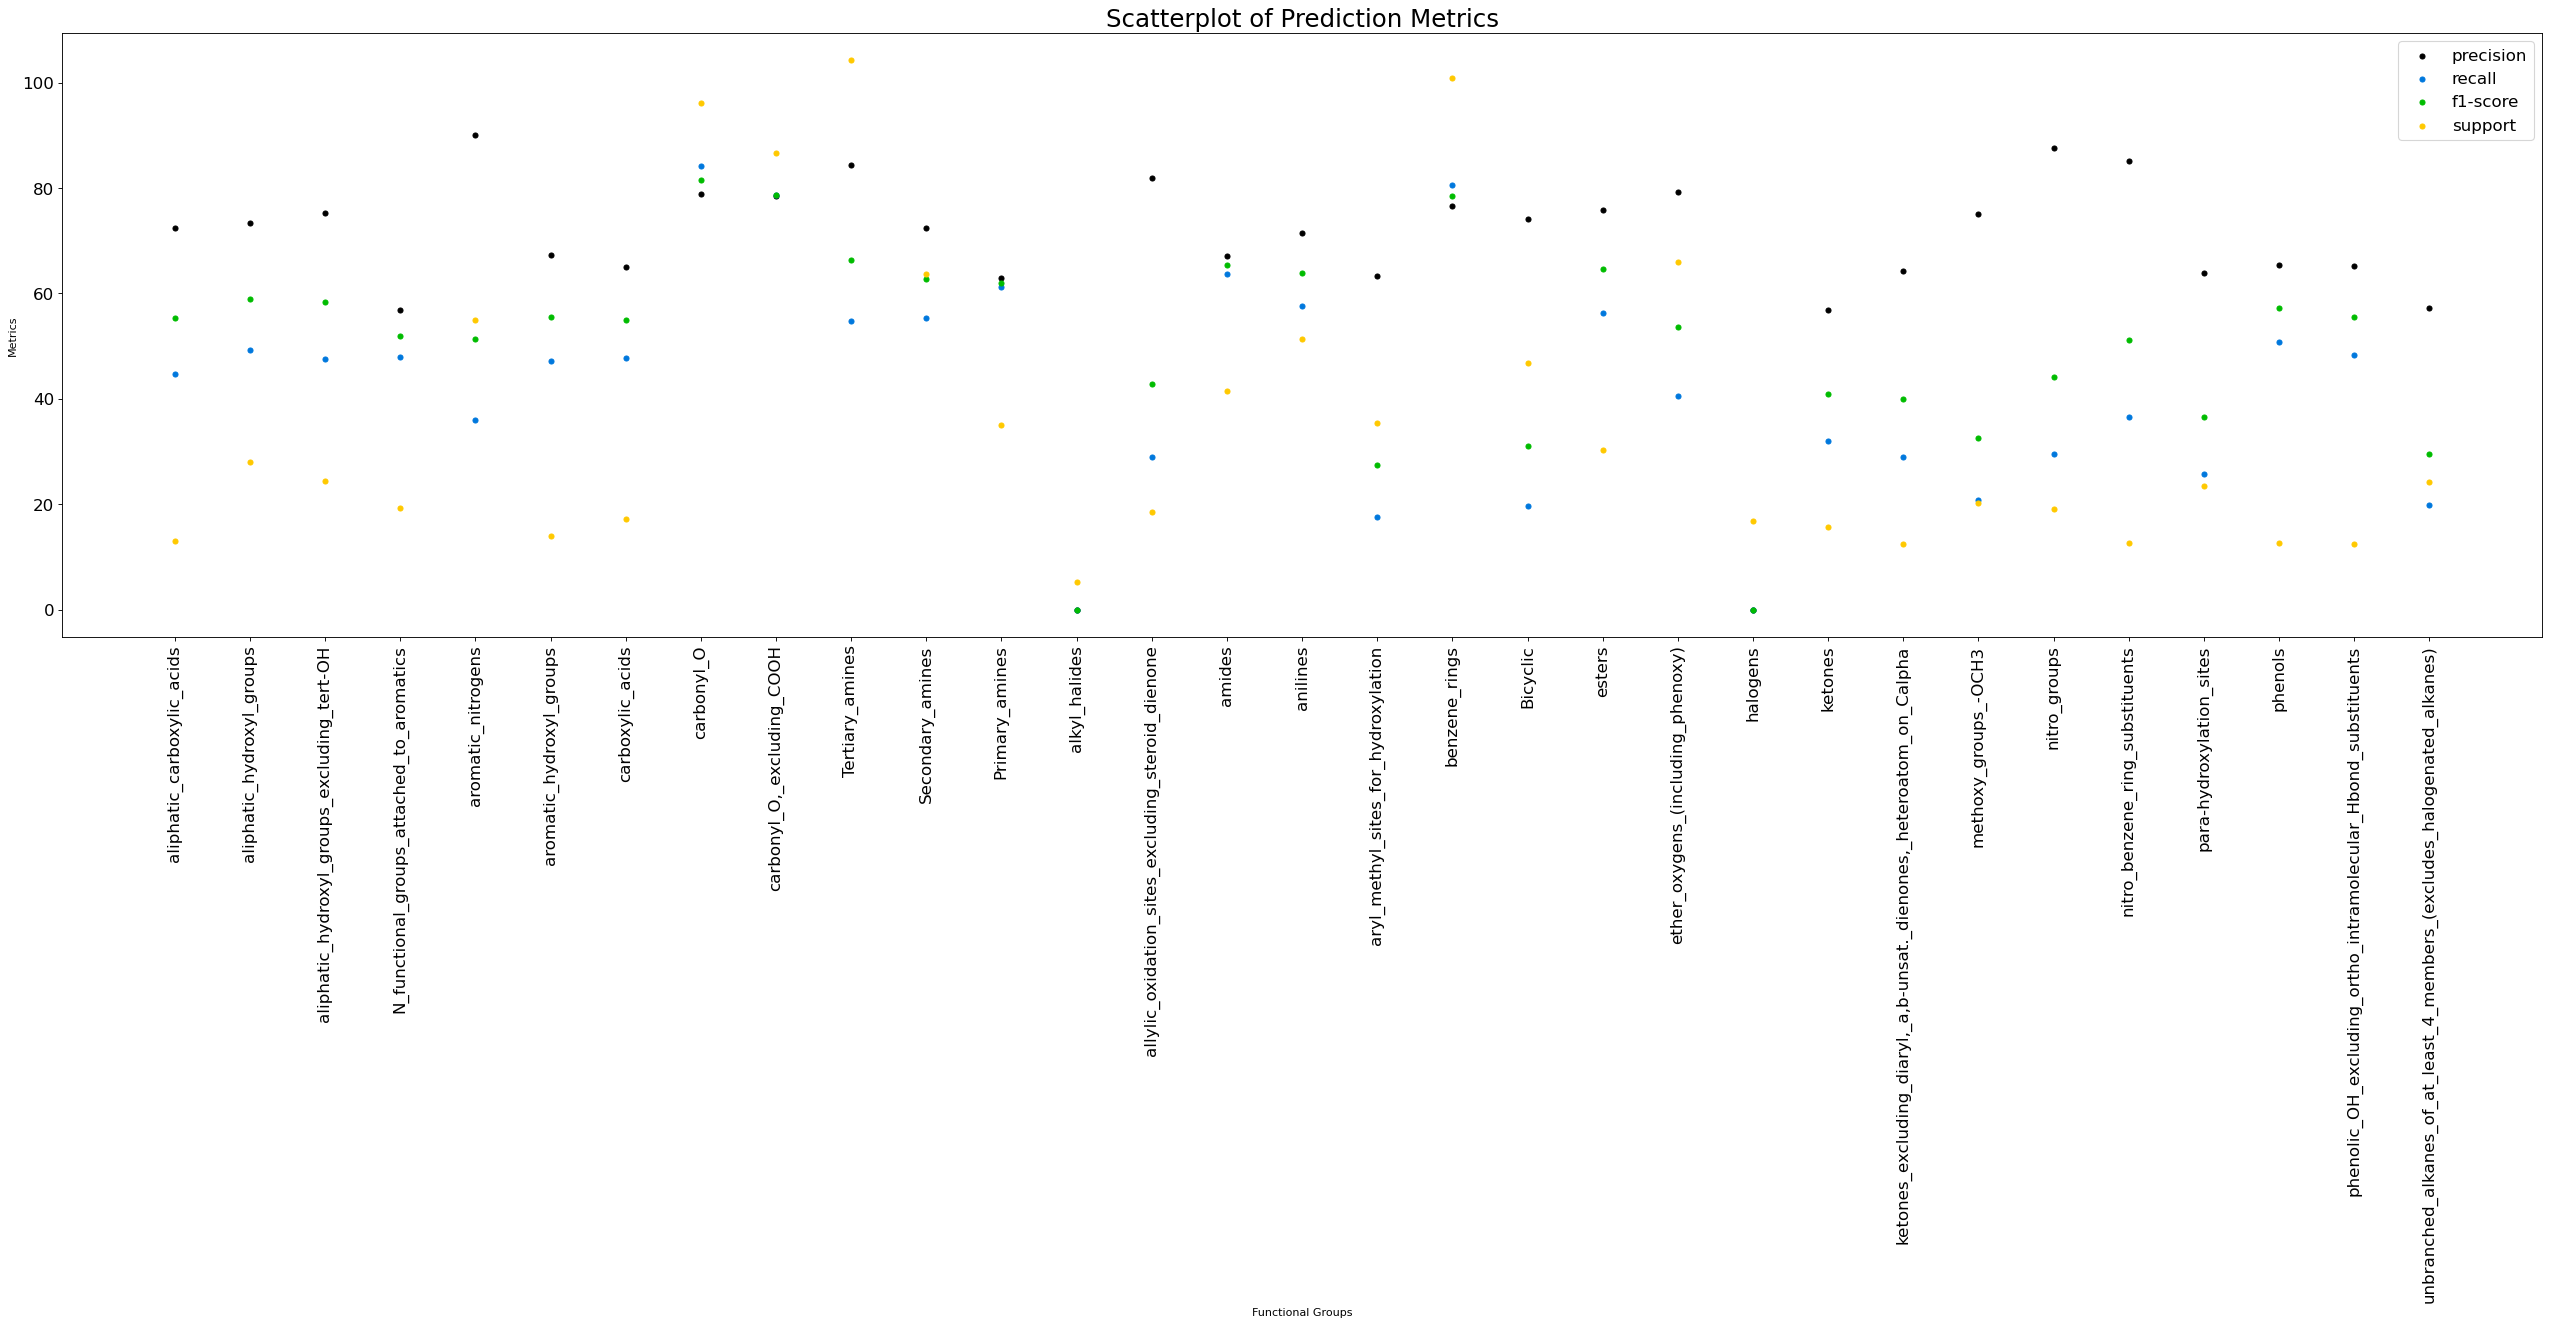

In [ ]:
categories = predictions.columns[:-1]
#colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]
colors = [plt.cm.nipy_spectral(float(i) / len(categories)) for i in range(len(categories))]

# Draw Plot for Each Category
plt.figure(figsize=(40, 10), dpi= 80, facecolor='w', edgecolor='k')

for i, category in enumerate(categories):
#    for fg in prediction['Functional Group']:
    plt.scatter('Functional Group', category, 
                data=predictions.iloc[:31,:], 
                s=20, c=colors[i], label=category)

# Decorations
plt.gca().set(xlabel='Functional Groups', ylabel='Metrics')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation='vertical')
plt.title("Scatterplot of Prediction Metrics", fontsize=22)
plt.legend(fontsize=15)    
plt.show()

In [ ]:
testPredictions = []
for i in range(pred_test.shape[0]):
    functionalGroups = []
    for col in range(pred_test.shape[1]):
        if round(pred_test[i][col]) == 1:
            functionalGroups.append("'" + labels.columns[col] +"'")
    testPredictions.append([output.iloc[i, 2601], functionalGroups])


In [ ]:
pd.DataFrame(testPredictions, columns=['Compound', 'Functional Groups'])

,Compound,Functional Groups
0,"(1H)-1,2,3-Triazole-4-carboxamide,5-amino-1-benzyl-",['unbranched_alkanes_of_at_least_4_members_(excludes_halogenated_alkanes)']
1,"(2,5-Dimethoxyphenyl)acetone","['carbonyl_O', 'carbonyl_O,_excluding_COOH', 'Secondary_amines', 'amides', 'anilines', 'benzene_rings']"
2,(5-Nonyl)pyrazine,"['carbonyl_O,_excluding_COOH', 'Tertiary_amines', 'aryl_methyl_sites_for_hydroxylation', 'benzene_rings']"
3,(E)-Stilbene,"['carbonyl_O', 'carbonyl_O,_excluding_COOH', 'Tertiary_amines', 'benzene_rings']"
4,"(R,R)-Tartaric acid","['carbonyl_O', 'carbonyl_O,_excluding_COOH', 'Primary_amines', 'amides']"
...,...,...
1015,o-METHYL CAPROLACTIM,"['carbonyl_O', 'carbonyl_O,_excluding_COOH', 'benzene_rings', 'unbranched_alkanes_of_at_least_4_members_(excludes_halogenated_alkanes)']"
1016,p-Anisidine,['Tertiary_amines']
1017,p-Nitrobenzaldehyde,"['carboxylic_acids', 'carbonyl_O', 'carbonyl_O,_excluding_COOH', 'Secondary_amines', 'amides', 'anilines', 'benzene_rings', 'para-hydroxylation_sites']"
1018,p-Phenylazoresorcinol,"['aliphatic_hydroxyl_groups', 'aliphatic_hydroxyl_groups_excluding_tert-OH', 'carbonyl_O', 'carbonyl_O,_excluding_COOH', 'benzene_rings', 'Bicyclic', 'ketones', 'ketones_excluding_diaryl,_a,b-unsat._dienones,_heteroatom_on_Calpha']"


In [ ]:
pd.set_option('display.max_colwidth', None)
